In [1]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"

import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

import dyCombinedModel
from My_Jampy import JAM

import matplotlib.pyplot as plt

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_8/Simulation_Data/"

In [2]:
#Reading inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)           #DM component
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True) #PSF
x, y, vrms, erms              = np.loadtxt("Input/vrms_data.txt", unpack=True)      #vrms data

In [3]:
#True Values of Simulation
z_l     = 0.299                                                         #Redshift of lens
z_s     = 4.100                                                         #Redshift of source
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
gamma   = 1.00                                                          #PPN parameter
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, 0.00)                                  #anisotropy [ad]
inc     = 90                                                            #inclination [deg]
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                    (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)       #Deprojected axial ratio for inclination
qDM     = np.sqrt( qobs_dm[0]**2 - np.cos(inc_rad)**2)/np.sin(inc_rad)  #Deprojected DM axial ratio
kappa_s = 0.075                                                         #kappa_s of DM profile
r_s     = 18.0                                                          #Scale radius [arcsec]
ml      = 7.20                                                          #mass to light ratio
phi_shear = 88                                                          #Inclination of external shear [deg]
mag_shear = 0.02                                                        #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

pixsize = 0.2    #MUSE pixel size
print("qInc: %.4f" %qinc)
print("qDM: %.4f"  %qDM)                        #MUSE pixel size

qInc: 0.5500
qDM: 0.8500


In [4]:
#Reading Image Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/image.fits",
        noise_map_path=f"{data_folder}/noise_map.fits",
        psf_path=f"{data_folder}/psf.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


#aplt.Imaging.subplot_imaging(
#    imaging=imaging, mask=mask, include=aplt.Include(border=True),                         #Plot
#)

In [5]:
#Starting Jampy Model
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)

#Add DM component
Jam_model.DM_component(surf_dm=kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [6]:
#Starting Autolens Model
#Elliptical components in Pyautolens units
ell_comps = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s, elliptical_comps=ell_comps, scale_radius=r_s) #elliptical NFW

mass_profile = al.mp.MGE()                            #MGE mass model
mass_profile.Analytic_Model(analytic_profile=eNFW)   #Include the analytical pENFW

#Components
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh) #DON'T INCLUDE THE MGE PARAMETRIZATION OF DM

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [7]:
#Starting dyCombined Model

model_MGE = dyCombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile,
                                 masked_imaging=masked_image, quiet=False)
#Setup Configurations
model_MGE.mass_to_light(ml_kind='scalar')                                          #Setting scalar ML
model_MGE.beta(beta_kind='scalar')                                                 #Seting vector anisotropy
model_MGE.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Dynamical")#Setting Dark matter component
model_MGE.include_DM_analytical(analytical_DM=eNFW)                                #Analytical eNFW


Change qinc limits to [0.0501, 0.55], defaults are [0.0, 1]


ParsDic {'ml': 7.2, 'beta': 0.0, 'qinc': 0.55, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.85, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.63
inc=90.0 beta_z=0.00 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 1.145e+14
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 18.0
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: 691.7504209123465
Log Likelihood: 1023.4218977269674
Log Normalization -2067.1679603253233
Log Evidence: 403.78871634247855
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kap

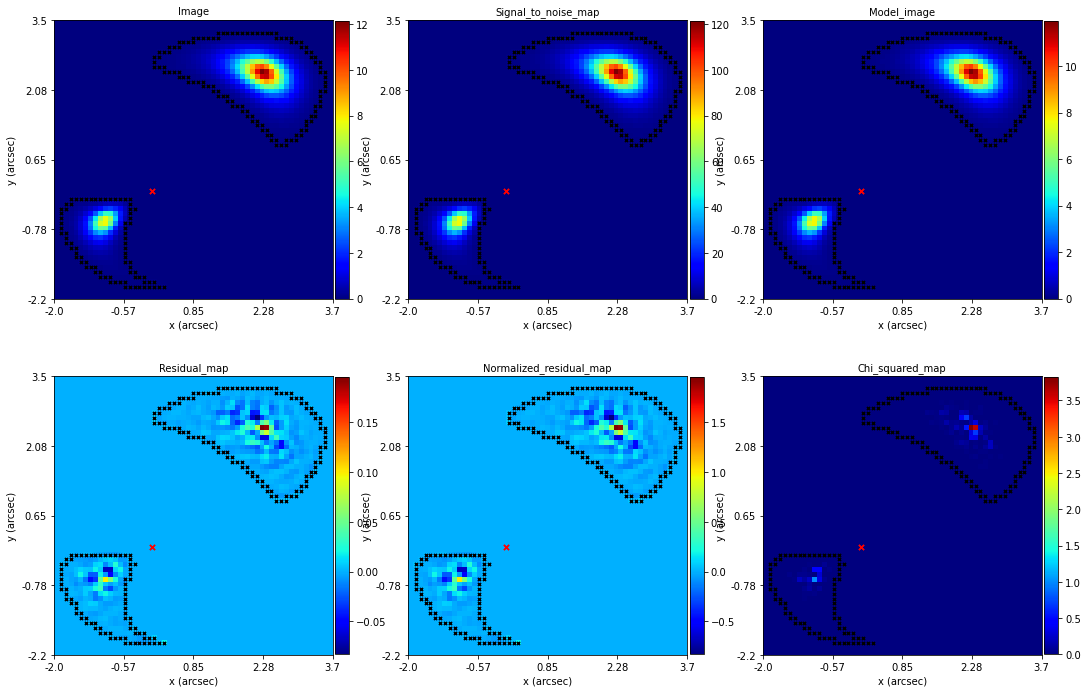

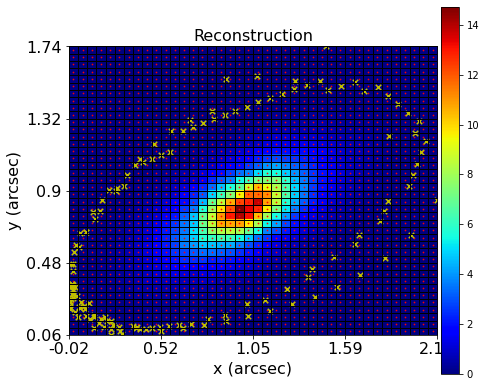

353.78872985502835

In [8]:
#Just Testing dyCombinedModel
#In order: ML, beta, qinc, log_mbh, kappa_s, qDM, mag_shear, phi_shear, gamma 
truth = np.array([ml, beta[0], qinc, np.log10(mbh), kappa_s, qDM, mag_shear, phi_shear, gamma])
label = ["ML", "beta", "qinc", "log_mbh", "kappa_s", "qDM", "mag_shear", "phi_shear", "gamma"]
model_MGE(truth) 

In [9]:
#In order: ML, beta, qinc, log_mbh, kappa_s, qDM, mag_shear, phi_shear, gamma 
from scipy.special import ndtri
boundary = model_MGE.boundary
def prior_transform(theta):
    """
    Flat Prior for all parameters, except for the gamma which have a gaussian prior centered in GR, i.e, 1.00
    """
    ml, beta, qinc, log_mbh, kappa_s, qDM, mag_shear, phi_shear, gamma = theta          #parameters on the unit cube
    parsDic = {"ml": ml, "beta":beta, "qinc": qinc,
                   "log_mbh":log_mbh, "kappa_s": kappa_s, "qDM":qDM,
                   "mag_shear": mag_shear, "phi_shear": phi_shear, 
                    "gamma": gamma}
    
    keys = set(parsDic.keys())                                      #All parameters
    
    #Frist the prior on gamma
    gamma_0      = 1.00       #mean
    sigma_gamma  = 0.05       #sigma/std
    
    parsDic['gamma'] = gamma_0 + sigma_gamma*ndtri(parsDic['gamma']) #Convert back to physical gamma
    excludes = set(['gamma'])  #Exclude gamma, because we already verify above
    
    for key in keys.difference(excludes): #Loop over the remains parameters
        parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
     
    return np.array(list(parsDic.values()))

def log_likelihood(pars):
    return model_MGE(pars)

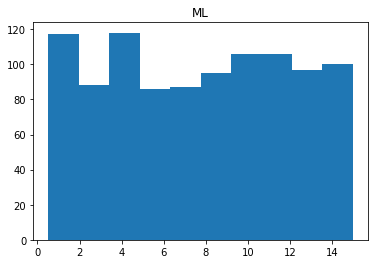

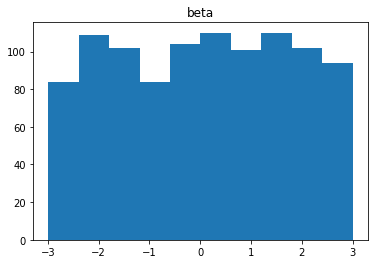

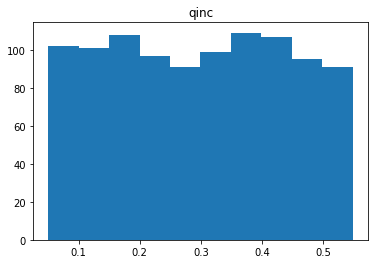

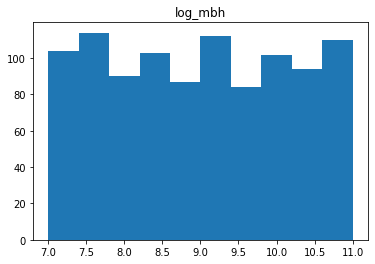

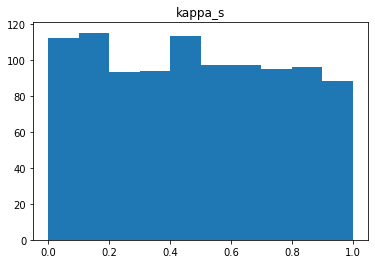

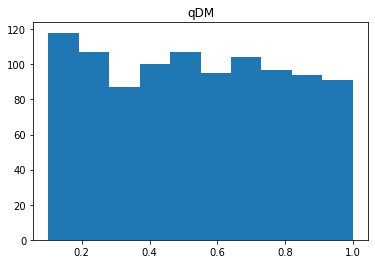

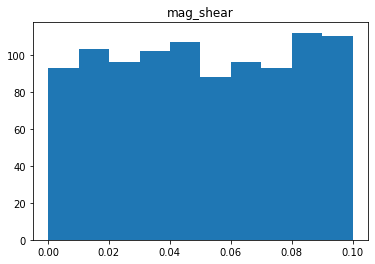

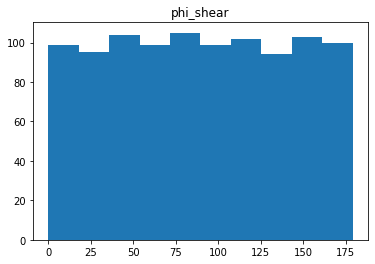

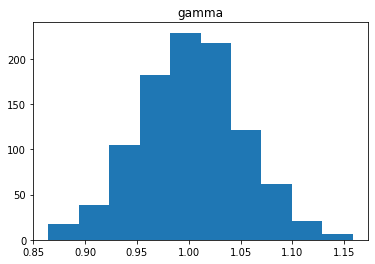

In [57]:
#Just checking the priors
import matplotlib.pyplot as plt
sample_u = np.random.rand(9, 1000)

label = ["ML", "beta", "qinc", "log_mbh", "kappa_s", "qDM", "mag_shear", "phi_shear", "gamma"]
for i in range(9):
    plt.hist(prior_transform(sample_u)[:,:][i])
    plt.title(label[i])
    plt.show()

ParsDic {'ml': 7.2, 'beta': 0.0, 'qinc': 0.55, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.85, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.64
inc=90.0 beta_z=0.00 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 1.145e+14
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 18.0
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: 691.7504209123465
Log Likelihood: 1023.4218977269674
Log Normalization -2067.1679603253233
Log Evidence: 403.78871634247855
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kap

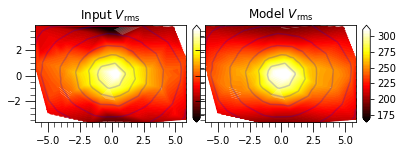

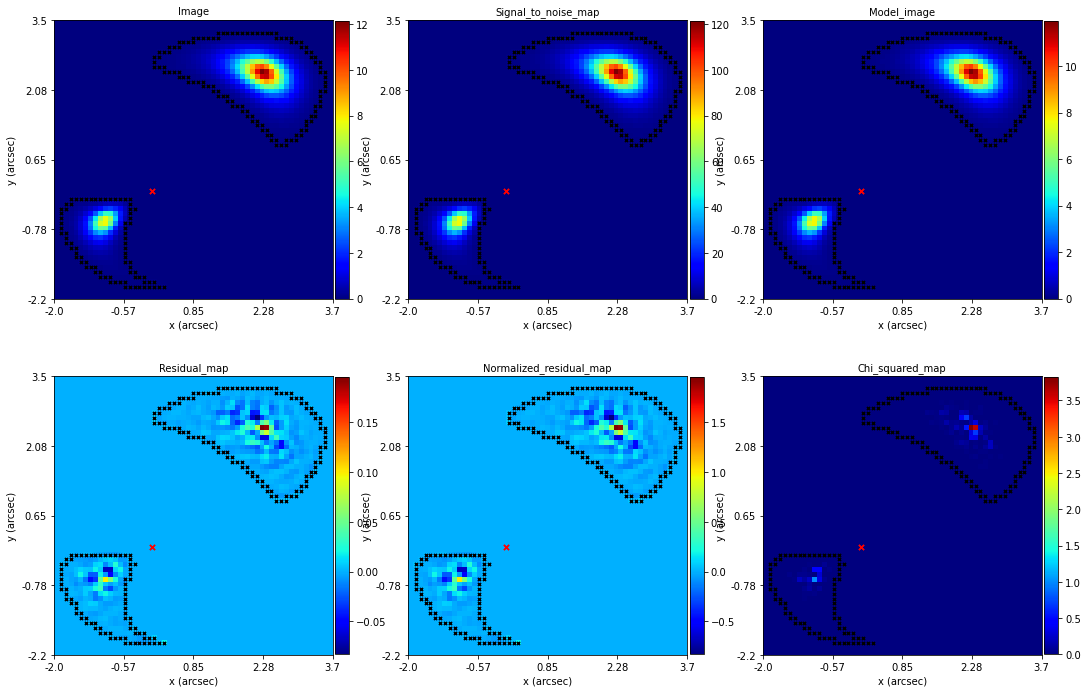

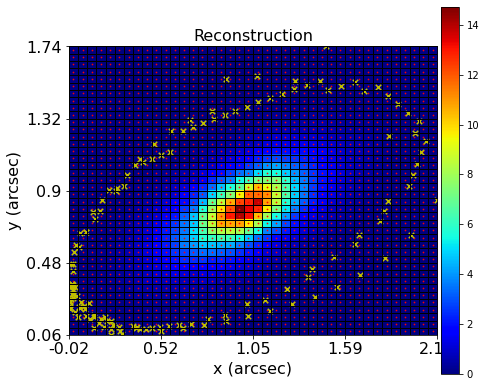

353.78872985502835

In [10]:
#Checking the log_likelihood call
log_likelihood(truth)

In [27]:
from dynesty import NestedSampler
from multiprocessing import Pool

In [28]:
nlive = 10              #number of (initial) live points
ndim  = truth.size       #number of dimensions



# Now run with the static sampler
sampler = NestedSampler(log_likelihood, prior_transform, ndim, pool=Pool(),queue_size=6,
                        nlive=nlive, sample="rwalk", walks=50)

ParsDicParsDicParsDicParsDicParsDicParsDicParsDicParsDic 

In [ ]:
sampler.run_nested(dlogz=0.01)

# Results 

In [11]:
import pickle 
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [12]:
with open(f'dynesty_lens_final.pickle','rb') as f:
    run1 = pickle.load(f)

In [13]:
run1.results["logz"].shape

(1942,)

In [15]:
with open(f'dynesty_lens_final2.pickle','rb') as f:
    run2 = pickle.load(f)

In [16]:
run2.results["logz"].shape

(1740,)

In [17]:
with open(f'dynesty_lens_final3.pickle','rb') as f:
    run3 = pickle.load(f)

In [18]:
run3.results["logz"].shape

(2111,)

In [19]:
# Adding the final set of live points.
for it_final, res in enumerate(run3.add_live_points()):
    pass

ValueError: The remaining live points have already been added to the list of samples!

In [20]:
run1.results.summary()

Summary
nlive: 40
niter: 1902
ncall: 73915
eff(%):  2.627
logz: 328.471 +/-  1.345


In [21]:
run2.results.summary()

Summary
nlive: 40
niter: 1700
ncall: 62280
eff(%):  2.794
logz: 330.478 +/-  1.276


In [22]:
run3.results.summary()

Summary
nlive: 40
niter: 2071
ncall: 79202
eff(%):  2.665
logz: 328.768 +/-  1.325


In [29]:
rlist = []
rlist.append(run1.results)
rlist.append(run2.results)
rlist.append(run3.results)
merge_results = dyfunc.merge_runs(rlist)

Merge: 2/3     

In [31]:
merge_results.niter

5793

In [32]:
# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(merge_results)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean

array([7.18571649e+00, 1.96143772e-02, 5.03880476e-01, 8.25446660e+00,
       7.74524920e-02, 8.47682740e-01, 1.96492253e-02, 8.17840463e+01,
       9.73896781e-01])

In [33]:
cov

array([[ 4.10442594e-03, -5.04382833e-04,  8.70064376e-04,
        -2.32915779e-02, -1.17964078e-04,  1.80304249e-04,
         4.57790756e-05, -3.74414995e-02,  2.79942943e-04],
       [-5.04382833e-04,  3.39472274e-04, -4.31437538e-04,
        -7.17189380e-04,  1.12216747e-05,  3.48309989e-04,
         5.74221652e-05,  3.54945830e-04, -1.01020707e-04],
       [ 8.70064376e-04, -4.31437538e-04,  7.48212702e-04,
        -1.57274615e-03, -3.22755816e-05, -2.49299072e-04,
        -4.64110759e-05, -2.69496578e-03,  2.01827199e-04],
       [-2.32915779e-02, -7.17189380e-04, -1.57274615e-03,
         4.11063518e-01,  4.69918163e-04, -3.89365790e-03,
        -8.24346740e-04,  6.29710013e-01,  7.14764521e-04],
       [-1.17964078e-04,  1.12216747e-05, -3.22755816e-05,
         4.69918163e-04,  5.25624228e-06, -2.84736059e-05,
        -4.84298044e-06, -1.12892696e-03, -1.82922541e-05],
       [ 1.80304249e-04,  3.48309989e-04, -2.49299072e-04,
        -3.89365790e-03, -2.84736059e-05,  7.103149

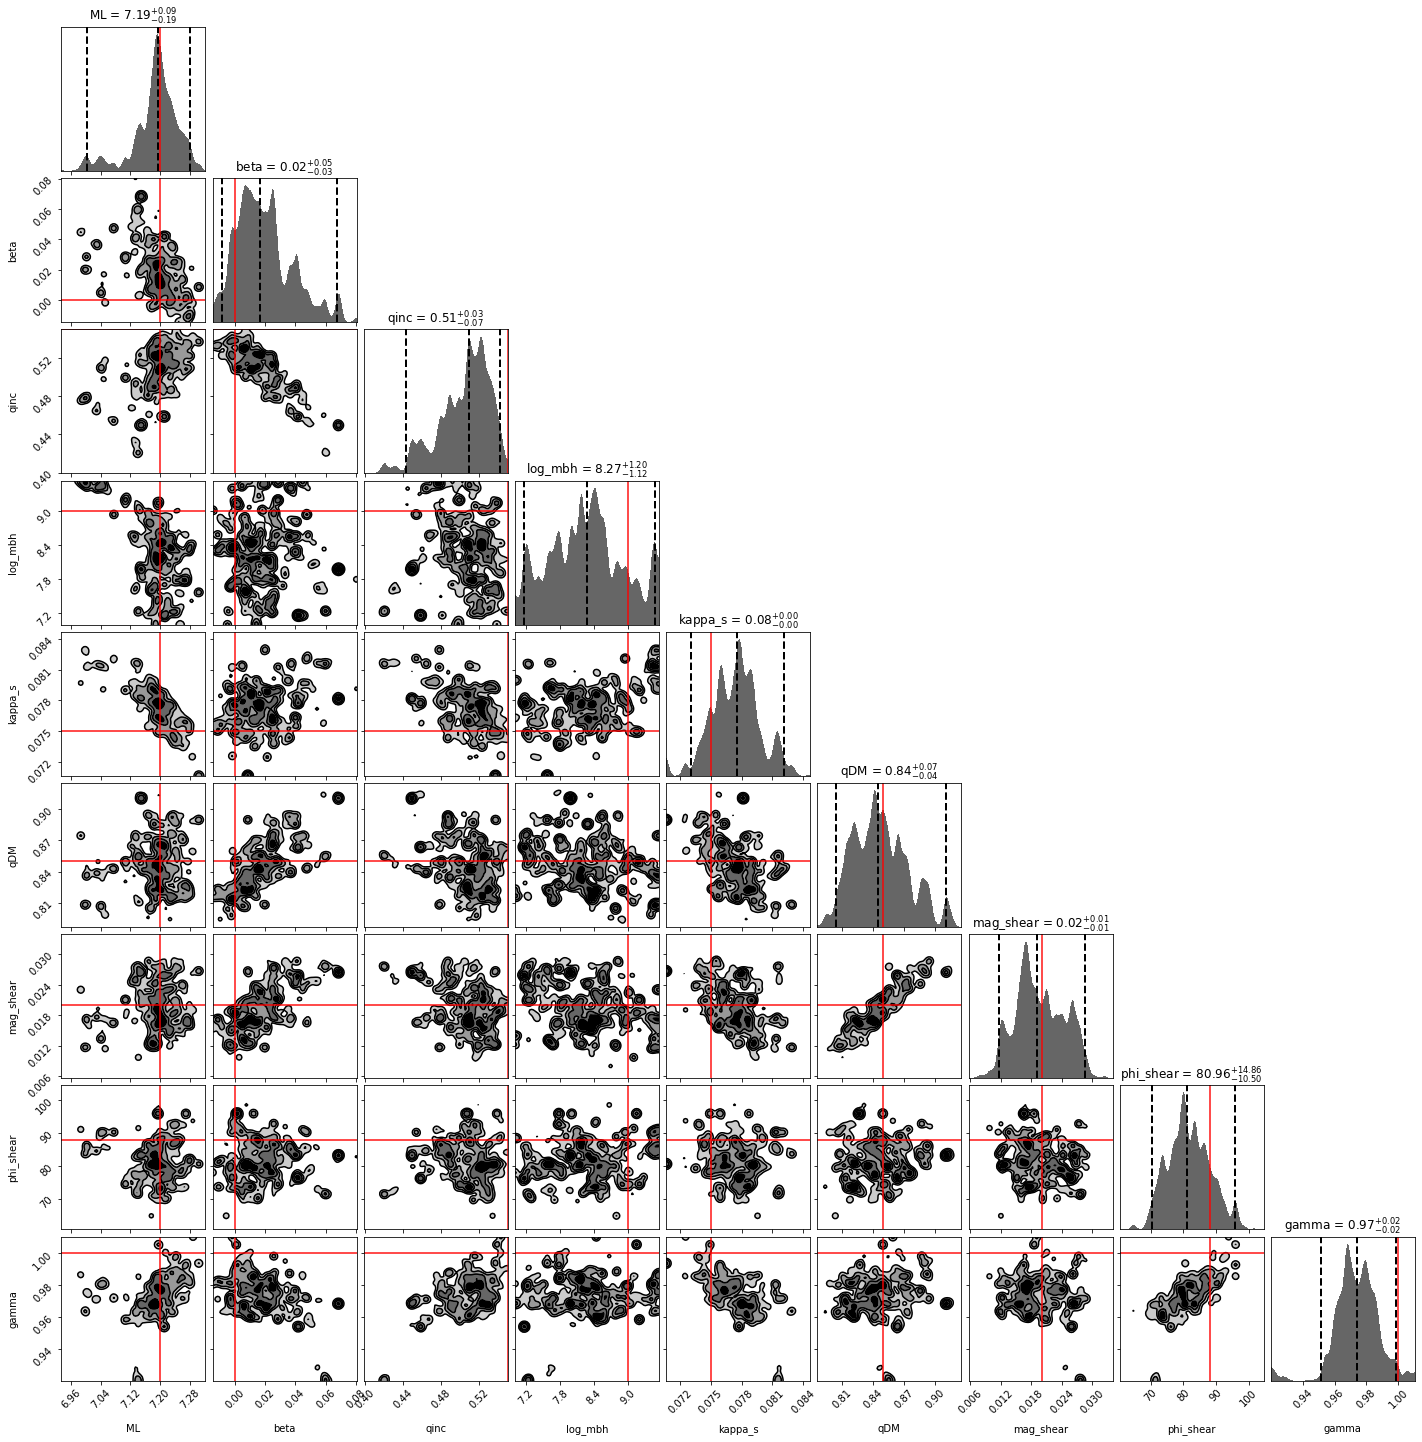

In [41]:
# Plot the 2-D marginalized posteriors.

cfig, caxes = dyplot.cornerplot(results_sim,truths=truth, show_titles=True,labels=label,
                               )

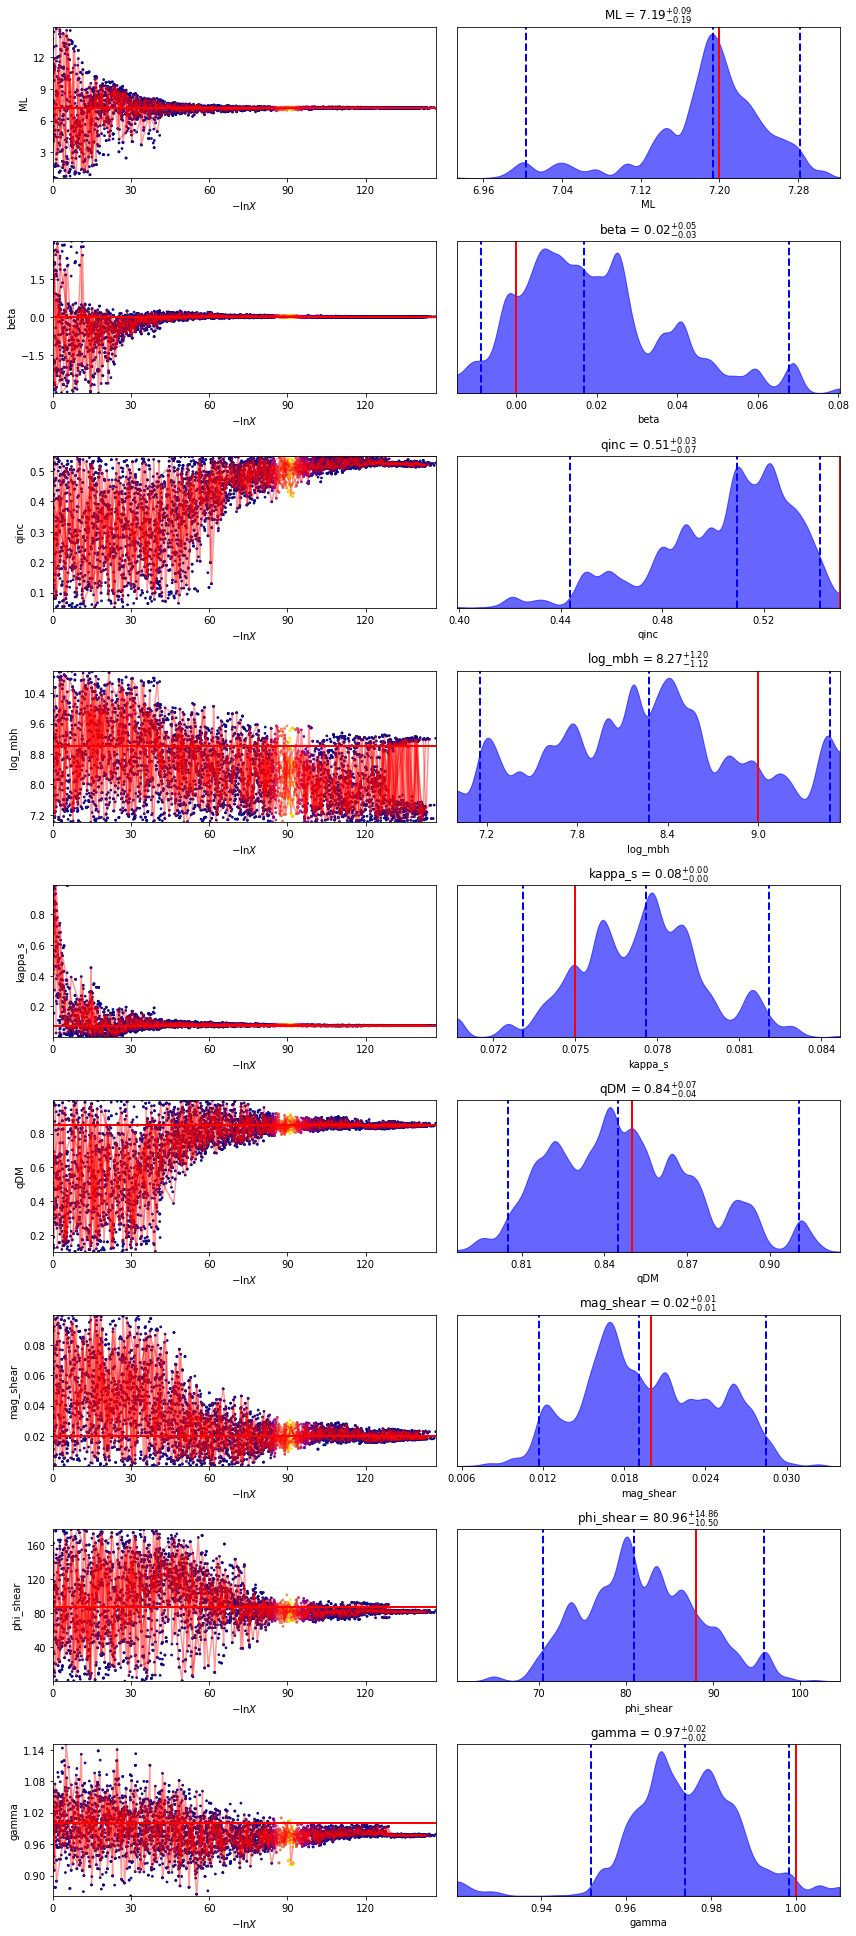

In [35]:
rfig, raxes = dyplot.traceplot(results_sim, labels=label,
                               truths=truth, show_titles=True, connect=True, connect_kwargs={'alpha':0.4})
plt.tight_layout()

In [36]:
mean

array([7.18571649e+00, 1.96143772e-02, 5.03880476e-01, 8.25446660e+00,
       7.74524920e-02, 8.47682740e-01, 1.96492253e-02, 8.17840463e+01,
       9.73896781e-01])

ParsDic {'ml': 7.185716488568123, 'beta': 0.01961437722834079, 'qinc': 0.5038804758651556, 'log_mbh': 8.254466597666058, 'kappa_s': 0.07745249202598574, 'qDM': 0.8476827401131746, 'mag_shear': 0.019649225328848666, 'phi_shear': 81.78404626068911, 'gamma': 0.9738967807786143}
jam_axi_rms elapsed time sec: 0.63
inc=75.2 beta_z=0.02 M/L=1 BH=1.80e+08 chi2/DOF=1.14
Total mass MGE: 1.194e+14
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0761779497770931)
axis_ratio: 0.8584287109899033
phi: 0.0
kappa_s: 0.07745249202598574
scale_radius: 18.0
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: 693.7735374007855
Log Likelihood: 1023.562228017483
Log Normalization -2067.1679603253233
Log Evidence: 405.4101209158963
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma:

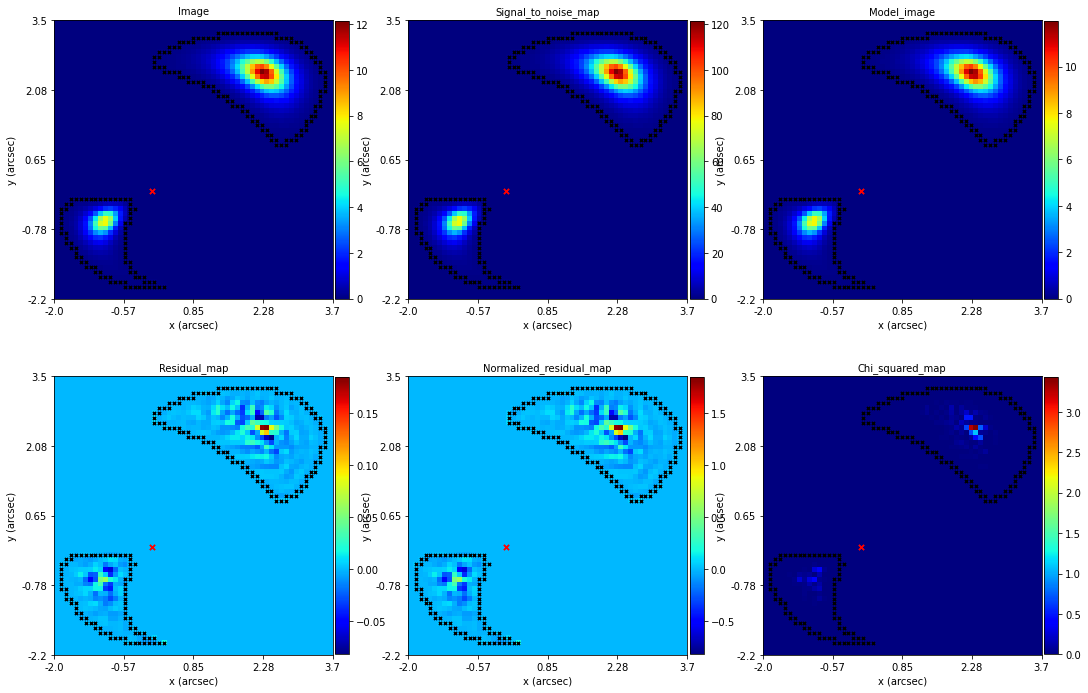

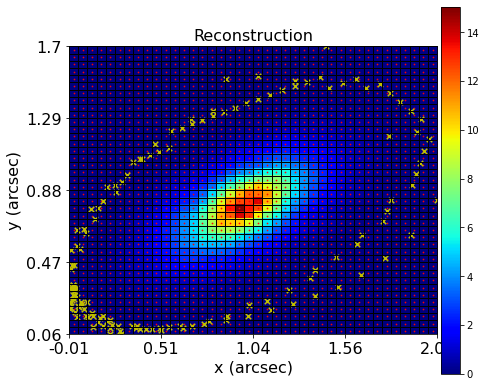

348.48828706496124

In [37]:
log_likelihood(mean)

In [44]:
caxes.shape

(9, 9)

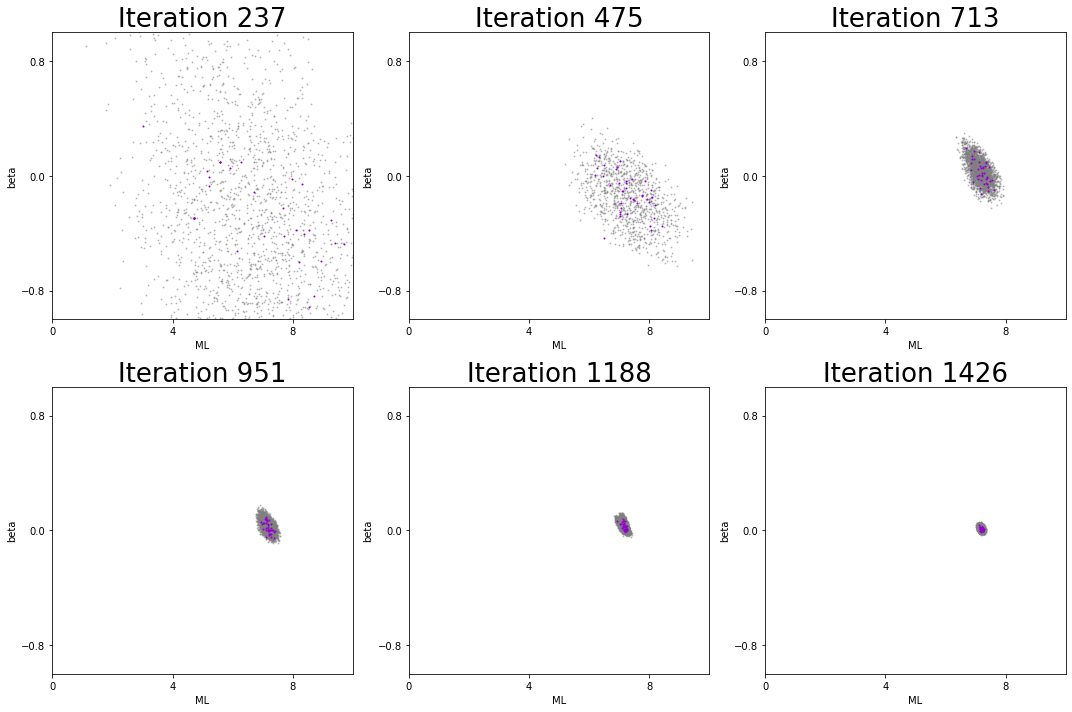

In [71]:
# initialize figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*run1.results.niter/8.)
    # overplot the result onto each subplot
    temp = dyplot.boundplot(run1.results, dims=(0, 1), it=it,
                            prior_transform=prior_transform,
                            max_n_ticks=3, show_live=True,
                            span=[(0, 10), (-1, 1)],
                            fig=(fig, a), labels=label)
    a.set_title('Iteration {0}'.format(it), fontsize=26)
fig.tight_layout()


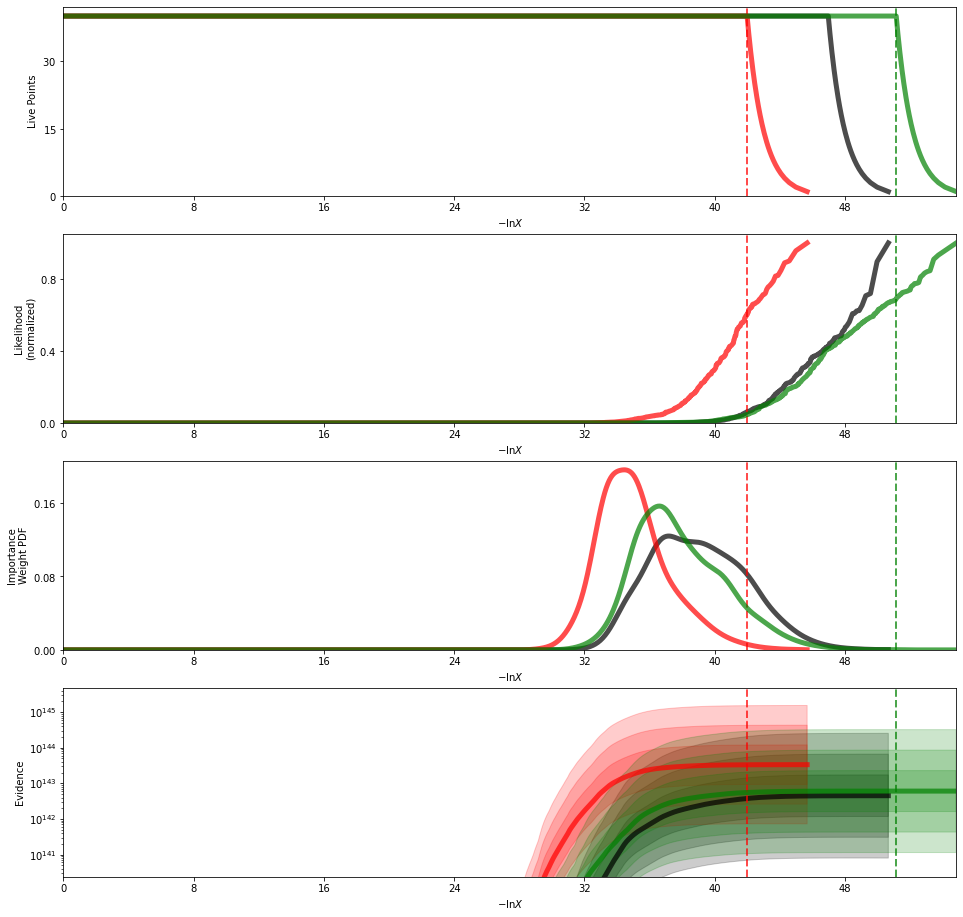

In [90]:
fig, axes = dyplot.runplot(run1.results, color='black', mark_final_live=False,
                           logplot=True)  # static run
fig, axes = dyplot.runplot(run2.results, color='red', logplot=True,
                           fig=(fig, axes))  # default dynamic run
fig, axes = dyplot.runplot(run3.results, color='green', logplot=True,
                           fig=(fig, axes))  # default dynamic run